In [2]:
USERNAME="SPKF2AA"
PASSWORD="test1234"
MDSS_SSID="AZK1"
DB2_SSID="DBBG"

import pandas as pd
import numpy as np
import dsdbc

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

In [3]:
def cp1047_to_utf8(list):
    list_out = []
    for e in list:
        x = ()
        for i in e:
            if isinstance(i, (str,)):
                s = i.encode('utf16').decode('cp1047').encode('utf8').decode('utf16')[2:]
                x = x + (s,)
            else:
                x = x + (i,)
        list_out.append(x)
    return list_out

def load_data_from_mds(vtable_name, user, password, mds_id=MDSS_SSID):
    conn =dsdbc.connect(SSID=mds_id, user=user, password=password)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM " + vtable_name)
    rows = cursor.fetchall()
    label = []
    for col in cursor.description: label.append(col[0].lower())
    conn.close()
    return pd.DataFrame(rows, columns=label)

def load_data_from_db2(table_name, user, password, mds_id=MDSS_SSID,  db2_id=DB2_SSID):
    conn =dsdbc.connect(SSID=mds_id, user=user, password=password, dsid=db2_id)
    cursor = conn.cursor()
    sql = "SELECT * FROM " + table_name
    #print(sql)
    cursor.execute(sql)
    rows = cp1047_to_utf8(cursor.fetchall())
    label = []
    for col in cursor.description: label.append(col[0].lower())
    conn.close()
    return pd.DataFrame(rows, columns=label)


In [4]:
txn_df = load_data_from_db2(table_name='SPARKDB.SPPAYTB1', user=USERNAME, password=PASSWORD)

In [5]:
txn_df['acaureq_aureq_tx_dt_ttlamt'] = pd.to_numeric(txn_df['acaureq_aureq_tx_dt_ttlamt'])
txn_df['cont_id'] = txn_df['cont_id'].astype('int64')
txn_df['acaureq_hdr_credtt'] = pd.to_datetime(txn_df['acaureq_hdr_credtt'])

txn_df['date'] = txn_df['acaureq_hdr_credtt'].apply(lambda x: x.date())
txn_df.head(5)

,acaureq_hdr_credtt,acaureq_aureq_env_a_id_id,acaureq_aureq_env_m_id_id,acaureq_aureq_env_m_cmonnm,acaureq_aureq_env_cpl_pan,acaureq_aureq_env_c_cardbrnd,acaureq_aureq_tx_mrchntctgycd,acaureq_aureq_tx_dt_ttlamt,cont_id,mdm_postal_code_id,age,authorresult_rspnt,fraud_ver_result,date
0,2013-04-02 22:47:00.001,BancaItaliana,C0120580917273555,Don't be alone,1009549375,Visa Gold,7273,84.87,1009549370,C012058091,51,APPR,N,2013-04-02
1,2013-01-19 16:55:12.001,BancaItaliana,C0120580915621418,Donna Elegante,1009549375,Visa Gold,5621,179.43,1009549370,C012058091,51,APPR,N,2013-01-19
2,2013-06-03 17:58:05.001,BancaItaliana,C0120580915311606,Rinascimento,1009549375,Visa Gold,5311,140.34,1009549370,C012058091,51,APPR,N,2013-06-03
3,2013-06-02 22:02:00.001,BancaItaliana,C0120580915814746,Eat and Go,1009549375,Visa Gold,5814,144.10,1009549370,C012058091,51,APPR,N,2013-06-02
4,2013-03-02 14:00:00.001,BancaItaliana,C0120580915992763,Florists,1009549375,Visa Gold,5992,111.73,1009549370,C012058091,51,APPR,N,2013-03-02


In [6]:
client_df = load_data_from_mds(vtable_name='VSAM_CLIENT', user=USERNAME, password=PASSWORD)

In [7]:
client_df = load_data_from_mds(vtable_name='VSAM_CLIENT', user=USERNAME, password=PASSWORD)
client_df = client_df.set_index("cont_id")
client_df.head(5)

,gender,age_years,highest_edu,annual_invest,annual_income,activity_level,churn,record_id
cont_id,,,,,,,,
1009520370,1,63.23,4,0.0,13035.0,3,0,0
1009520380,1,58.51,1,0.0,18267.0,0,0,600
1009520390,0,31.10,2,111192.0,129276.0,2,0,1200
1009520400,0,49.84,1,0.0,17867.0,2,0,1800
1009520410,1,53.33,1,0.0,17576.0,1,0,2400


In [8]:
# Ashish did the changes as the resultant data frame need to join with original dataframe. Seems the existing code is doing other way round.
#Total transactions per customer
#total_txns_df = txn_df.groupby('cont_id').size().rename("total_txns").to_frame()
#client_df = client_df.join(total_txns_df)
total_txns_df = txn_df.groupby('cont_id').size().rename("total_txns").to_frame()
client_df = total_txns_df.join(client_df)

#Total transaction amount per customer
#total_txn_amt = txn_df.groupby('cont_id')['acaureq_aureq_tx_dt_ttlamt'].sum().rename("txn_amt").to_frame()
#client_df = client_df.join(total_txn_amt)
total_txn_amount_df = txn_df.groupby('cont_id')['acaureq_aureq_tx_dt_ttlamt'].sum().rename("total_txn_amount").to_frame()
client_df = client_df.join(total_txn_amount_df)

# Avg transaction amounts per customer
#avg_txn_amount = txn_df.groupby('cont_id')['acaureq_aureq_tx_dt_ttlamt'].mean().rename("avg_txn_amount").to_frame()
#client_df = client_df.join(avg_txn_amount)
avg_txn_amount_df = txn_df.groupby('cont_id')['acaureq_aureq_tx_dt_ttlamt'].mean().rename("avg_txn_amount").to_frame()
client_df = client_df.join(avg_txn_amount_df)

# Average daily txns per customer
daily_txns = txn_df.groupby(['date', 'cont_id']).size()

# Missing txns on a particular day means customer had none.
# These days should be included in the avg as 0 transaction days.
avg_daily_txns_df = daily_txns.unstack().fillna(0).mean().rename("avg_daily_txns").to_frame()
client_df = client_df.join(avg_daily_txns_df)

client_df.head(3)

,total_txns,gender,age_years,highest_edu,annual_invest,annual_income,activity_level,churn,record_id,total_txn_amount,avg_txn_amount,avg_daily_txns
cont_id,,,,,,,,,,,,
1009525770,104,1,24.50,1,0.0,22318.0,2,0,327680,4159.56,39.995769,0.284932
1009526100,244,1,71.56,1,0.0,23688.0,0,1,347480,10196.84,41.790328,0.668493
1009526540,69,0,39.86,1,0.0,22628.0,3,0,374248,3591.61,52.052319,0.189041


In [9]:
#Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style(style='whitegrid')

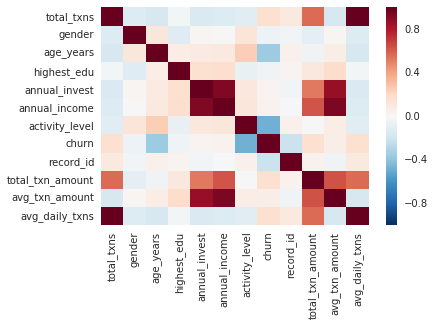

In [10]:
corr = client_df.corr()
sns.heatmap(corr)

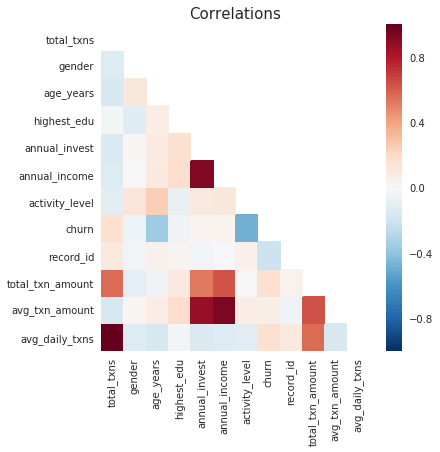

In [11]:
corr = client_df.corr()
#only the lower triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(corr, mask=mask, ax=ax)
title = ax.set_title('Correlations', size=15)

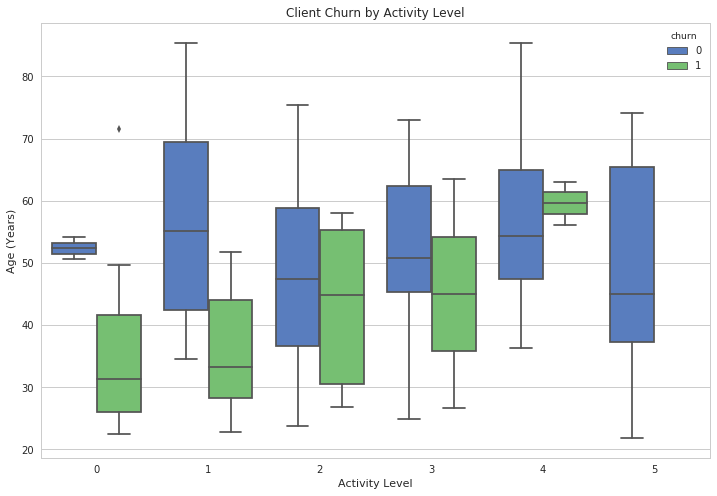

In [12]:
#distribution of clients who churned and didnot churn in the same axis
col = 'age_years'
f, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(x='activity_level', y=col, hue="churn", data=client_df, 
                 palette='muted', ax=ax)
title = ax.set_title('Client Churn by Activity Level')
label = ax.set_ylabel('Age (Years)')
label = ax.set_xlabel('Activity Level')
handles, labels = ax.get_legend_handles_labels()

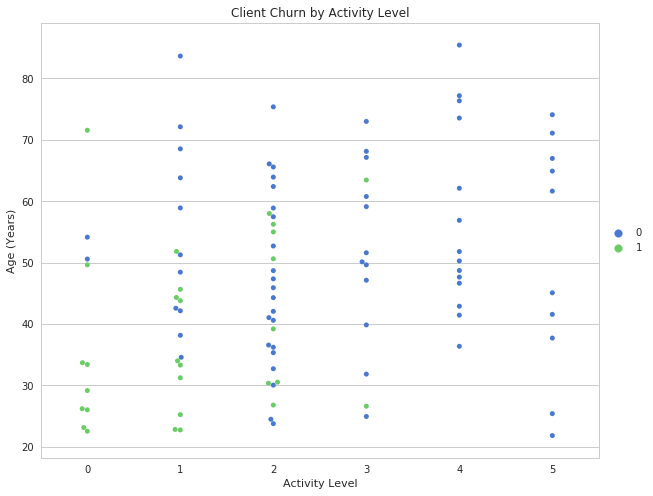

In [13]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.swarmplot(x='activity_level', y='age_years', hue='churn', data=client_df.sample(n=100, random_state=51),palette='muted',ax=ax)
title = ax.set_title('Client Churn by Activity Level')
label = ax.set_ylabel('Age (Years)')
label = ax.set_xlabel('Activity Level')
plt.legend(bbox_to_anchor=(1,0.5),loc='center left')

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

In [15]:
#splitting data into train and test sets
train_index, test_index = train_test_split(client_df.index, random_state=99)
train_df = client_df.ix[train_index]
test_df = client_df.ix[test_index]

#target variable in training set
train_y = np.array(train_df['churn'])

#extracting features in training set
train_features_df = train_df.drop(['churn','customer_id'],axis=1, errors ='ignore')
train_x = train_features_df.as_matrix().astype(np.float)
scalar = StandardScaler()
train_x = scalar.fit_transform(train_x)

#target variable in test set
test_y = np.array(test_df['churn'])

#extracting features in test set
test_features_df = test_df.drop(['churn','customer_id'],axis=1, errors ='ignore')
test_x =test_features_df.as_matrix().astype(np.float)
test_x = scalar.transform(test_x)

In [17]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RF
clf1 = RF(n_estimators=100)
clf1.fit(train_x, train_y)
pred_RF = clf1.predict_proba(test_x)[:,1]


In [18]:
output_df = test_df.copy()

In [22]:
output_df['churn_proba_RF'] = pred_RF

avg_daily_balance = output_df['annual_income']/6

deposit_rate = 0.02
credit_rate = 0.015
mgmt_rate = 0.02

#how much is each customer worth to the business?
output_df['worth'] = deposit_rate * avg_daily_balance + \
        mgmt_rate * output_df['annual_invest'] + \
        credit_rate * output_df['total_txn_amount']

# for RandomForestClassifier
output_df['predicted_loss_RF'] = output_df['churn_proba_RF'] * output_df['worth']

output_df.sort_values(by='predicted_loss_RF', ascending=False).head(5)

,total_txns,gender,age_years,highest_edu,annual_invest,annual_income,activity_level,churn,record_id,total_txn_amount,avg_txn_amount,avg_daily_txns,churn_proba_RF,worth,predicted_loss_RF
cont_id,,,,,,,,,,,,,,,
1009554080,192,0,22.55,2,113071.0,124132.0,0,1,2045416,21044.85,109.608594,0.526027,0.67,2990.866083,2003.880276
1009529950,301,0,30.36,2,86143.0,176189.0,2,1,581056,39737.90,132.019601,0.824658,0.35,2906.225167,1017.178808
1009528410,195,0,63.81,3,78373.0,93138.0,1,0,487552,16339.76,83.793641,0.534247,0.33,2123.016400,700.595412
1009547530,5,0,44.30,3,85402.0,73856.0,2,0,1648000,390.48,78.096000,0.013699,0.34,1960.083867,666.428515
1009528620,63,0,62.12,3,119243.0,171078.0,4,0,500520,8557.37,135.831270,0.172603,0.13,3083.480550,400.852471


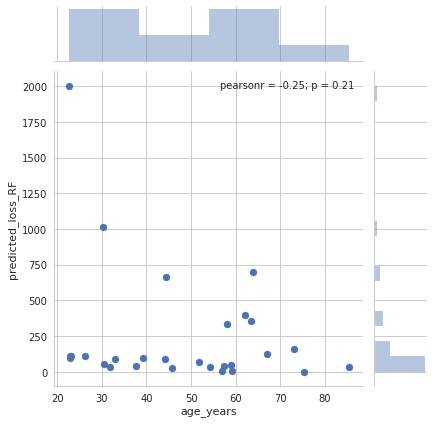

In [23]:
sns.jointplot('age_years','predicted_loss_RF', data=output_df)

In [25]:
def group_by_age(df, bins=None):
    if bins is None:
        bin_size = 5
        _min, _max = int(df.age_years.min()), int(df.age_years.max())
        bins = range(_min, _max + bin_size, 5)
    return df.groupby(pd.cut(df.age_years, bins=bins))

data_by_age = output_df.pipe(group_by_age)
data_by_age['predicted_loss_RF'].sum().reset_index()

,age_years,predicted_loss_RF
0,"(22, 27]",2426.236102
1,"(27, 32]",1102.292628
2,"(32, 37]",91.160552
3,"(37, 42]",134.908930
4,"(42, 47]",779.835028
5,"(47, 52]",68.753084
6,"(52, 57]",42.942677
7,"(57, 62]",433.643822
8,"(62, 67]",1580.857398
9,"(67, 72]",NaN


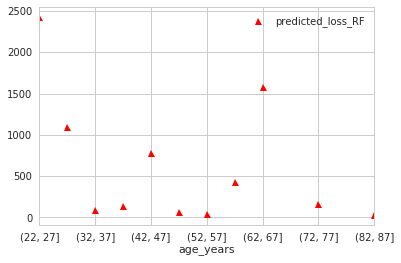

In [27]:
loss_by_age_df = data_by_age['predicted_loss_RF'].sum().reset_index()
loss_by_age_df['age_years'] = loss_by_age_df['age_years'].astype(str)

loss_by_age_df.plot(x='age_years', y='predicted_loss_RF', style='r^')